In [1]:
# unset PYTHONPATH first
from ko_text import *
from ko_crawler import *

import ast

In [2]:
nlp = NLP()

In [3]:
train_df = pd.read_csv('Data/morphs/train_morphs_final.csv', encoding = 'utf-8')
test_df = pd.read_csv('Data/morphs/test_morphs_final.csv', encoding = 'utf-8')

# 용량을 줄이기 위해 '단어 단어' 꼴로 묶어둔 token을 ['단어', '단어'] 꼴로 풀기
train_df['Token'] = [token.split() for token in train_df['Token']]
test_df['Token'] = [token.split() for token in test_df['Token']]

In [4]:
print(train_df.shape)

(82963, 3)


In [5]:
Counter(train_df['Section'])

Counter({'IT과학': 9836,
         '경제': 8050,
         '국제': 9677,
         '기업': 9604,
         '문화': 9313,
         '부동산': 9714,
         '사회': 9325,
         '정치': 8875,
         '증권': 8569})

In [6]:
train_token_ls = train_df['Token'].tolist()
train_label_ls = train_df['Section'].tolist()

test_token_ls = test_df['Token'].tolist()
test_label_ls = test_df['Section'].tolist()

In [7]:
train_token_ls, train_label_ls = nlp.extract_a_equally_splited_batch(train_token_ls, train_label_ls, 10000)

In [8]:
test_token_ls, test_label_ls = nlp.extract_a_equally_splited_batch(test_token_ls, test_label_ls, 1000)

# **Word2Vec + CNN**

In [9]:
from gensim.models import Word2Vec

class Word2VecCNN():
    
    def __init__(self, path_to_word2vec_model = ''):
        print('초기 세팅을 시작합니다.')
        print('사전에 학습된 Word2Vec 모델을 불러옵니다.')
        try: 
            self.w2v_model = Word2Vec.load(path_to_word2vec_model)
            print('학습된 Word2Vec 모델을 성공적으로 불러왔습니다.')
            
        except : 
            self.w2v_model = Word2Vec(min_count = 1)
            print('Word2Vec 모델을 불러오는데 실패하였습니다.')
            print('=================================================================================')
            print('Default 세팅의 Word2Vec 모델을 새롭게 생성합니다.')
            print('Process 진행에 앞서, Word2Vec 모델의 학습이 필요합니다.')
            print('bulid_and_train_w2v_model 함수를 사용하여, word2vec 모델을 학습하시기 바랍니다')
            print('=================================================================================')
            print('Word2Vec의 Hyperparameter 튜닝을 원하신다면 self.w2v_model을 새롭게 생성한 모델로 덮어 쓰시면 됩니다. ')
    
    
    def build_and_train_w2v_model(self, token_ls):
        '''
        Word2Vec 모델을 학습하는 함수입니다.
        
        inputs
        
        token_ls : iterable, 토큰이 리스트 형태로 저장된 리스트
        
        return
        모델 학습
        '''
        import logging
        #logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)

        self.w2v_model.build_vocab(token_ls)

        self.w2v_model.train(token_ls,
                            total_examples = self.w2v_model.corpus_count,
                            epochs = 10)
    
    
    def load_w2v_model(self, path_to_model):
        '''
        사전에 학습한 Word2Vec 모델을 불러오는 함수입니다.
        '''
    
        self.w2v_model = Word2Vec.load(path_to_model)
        return
    
    
    def generate_equal_sequence_doc_vector_for_cnn(self, doc, sequence_length = 10):
        '''
        한 개의 문서(token list)를 Word2Vec으로 벡터화하여, CNN학습에 적합한 4D로 변환하는 함수입니다.

        input
        doc : iterable, 토큰으로 구분된 array 형태의 문서
        w2v_model : word2vec_model, 개별 토큰을 벡터화하기 위한 word2vec 모델
        sequence_length : int, 한 문서 당, 최대 토큰의 수
        '''
        n_dim = self.w2v_model.vector_size
        
        if len(doc) < 1:
            return np.zeros((sequence_length,self.w2v_model.vector_size)).reshape(sequence_length, n_dim, -1)

        elif len(doc) < sequence_length:
            # 해당 단어가 w2v 모델에 있으면, 해당 벡터 값으로, 없으면 0벡터로 변환
            return_array = np.array([self.w2v_model.wv.__getitem__(token) if self.w2v_model.wv.__contains__(token) else [0] * n_dim for token in doc])

            # 길이가 짧은 문서는 0백터로 max_len의 크기에 맞도록 패딩을 해준다.
            n_padding = sequence_length - len(doc)
            return_array = np.concatenate((return_array, np.zeros((n_padding, n_dim))))


        # 문서의 길이가 max_length보다 길면 앞에서 max_length의 토큰까지 짜른다.
        elif len(doc) >= sequence_length:
            # 해당 단어가 w2v 모델에 있으면, 해당 벡터 값으로, 없으면 0벡터로 변환
            return_array = np.array([self.w2v_model.wv.__getitem__(token) if self.w2v_model.wv.__contains__(token) else [0] * n_dim for token in doc[:sequence_length]])
        
        return return_array.reshape(sequence_length, n_dim,-1)
    
    
    
    
    def generate_equal_sequence_doc_vectors_for_cnn(self, doc_ls, sequence_length = 10):
        '''
        복수 개의 문서(token list)를 Word2Vec으로 벡터화하여, CNN학습에 적합한 4D로 변환하는 함수입니다.

        input
        doc_ls : iterable, 토큰으로 구분된 array 형태의 문서가 저장된 리스트
        sequence_length : int, 한 문서 당, 최대 토큰의 수
        '''
        
        return np.array([self.generate_equal_sequence_doc_vector_for_cnn(doc, sequence_length) for doc in doc_ls])
    
    
    
    
        
    def _init_weights(self,shape):
        '''
        CNN 학습을 위해, filter의 초기 weight를 주는 함수입니다.

        inputs 
        shape = 4D-array, [batch, n_height, n_width, n_channel] 
        '''
        return tf.Variable(tf.random_normal(shape, stddev=0.01))




In [10]:
w2v_cnn = Word2VecCNN('w2v_model')

초기 세팅을 시작합니다.
사전에 학습된 Word2Vec 모델을 불러옵니다.
학습된 Word2Vec 모델을 성공적으로 불러왔습니다.


In [11]:
#w2v_cnn.w2v_model = Word2Vec(min_count = 5, 
#                             window = 5,
#                             sample = 1e-05,
#                             size = 50)

In [12]:
#w2v_cnn.build_and_train_w2v_model(train_df['Token'].tolist() + test_df['Token'].tolist())

In [13]:
w2v_cnn.w2v_model.most_similar('인공')

[('지능', 0.9434113502502441),
 ('사물인터넷', 0.7708964347839355),
 ('음성인식', 0.7656369209289551),
 ('러닝', 0.7467309236526489),
 ('빅데이터', 0.7432914972305298),
 ('자연어', 0.7127903699874878),
 ('머신', 0.7089794278144836),
 ('로봇', 0.7075458765029907),
 ('기계학습', 0.6892430186271667),
 ('접목', 0.6829283237457275)]

## 학습을 위한 데이터 전처리

In [14]:
sequence_length = 100

In [15]:
train_X = w2v_cnn.generate_equal_sequence_doc_vectors_for_cnn(train_token_ls, sequence_length=sequence_length)
test_X = w2v_cnn.generate_equal_sequence_doc_vectors_for_cnn(test_token_ls, sequence_length=sequence_length)

train_Y = pd.get_dummies(train_label_ls).values.astype('float32')
test_Y = pd.get_dummies(test_label_ls).values.astype('float32')

In [16]:
train_X.shape, test_X.shape

((9999, 100, 100, 1), (999, 100, 100, 1))

## CNN 학습

In [17]:
import tensorflow as tf

In [18]:
n_dim = train_X.shape[2]

In [24]:
def init_weights(shape):
    return tf.Variable(tf.random_normal(shape, stddev=0.01))


tf.reset_default_graph()

def graph(X,
          p_keep_conv, 
          p_keep_hidden, 
          filter_size_ls = [2,3,4,5,6,7], 
          num_filter = 100, 
          sequence_length = 100,
          n_fc = 100, 
          n_class= 9,
          n_dim = n_dim):

    max_pool_result_ls = []
    
    # 각각의 사이즈의 필터를 num_filter개 생성하여 convolution & max_pool
    for filter_size in filter_size_ls:

        filter_ = init_weights([filter_size, n_dim, 1, num_filter])
        
        
        # l1_conv shape=(?, sequence_length - filter_size + 1, n_dim, num_filter)
        l1_conv = tf.nn.relu(tf.nn.conv2d(input = X,
                                      filter = filter_,  
                                      strides=[1, 1, 1, 1], 
                                      padding='VALID')) 
        # l1_pool shape=(?, 1, 1, num_filter)
        l1_pool = tf.nn.max_pool(l1_conv, 
                            ksize=[1, sequence_length - filter_size + 1, 1, 1], 
                            strides=[1, 1, 1, 1], 
                            padding='VALID')

        l1_pool = tf.nn.dropout(l1_pool, p_keep_conv)

        max_pool_result_ls.append(l1_pool)

    # 각기 다른 종류의 필터를 거쳐 conv-pool한 결과를 concat
    num_filter_total = num_filter * len(filter_size_ls)
    max_pool_concat = tf.concat(max_pool_result_ls, 3)
    max_pool_concat_flat = tf.reshape(max_pool_concat, [-1, num_filter_total])

    # fully-connect
    w_fc = init_weights([num_filter_total, n_fc])
    w_output = init_weights([n_fc, n_class])

    l = tf.nn.relu(tf.matmul(max_pool_concat_flat, w_fc))
    l = tf.nn.dropout(l, p_keep_hidden)

    h = tf.matmul(l, w_output)
    return h



In [25]:
sequence_length = sequence_length
n_class = train_Y.shape[1]

batch_size = 100
test_size = 300


In [26]:
X = tf.placeholder("float", [None, sequence_length, w2v_cnn.w2v_model.vector_size, 1])
Y = tf.placeholder("float", [None, n_class])

p_keep_conv = tf.placeholder("float")
p_keep_hidden = tf.placeholder("float")
h = graph(X, p_keep_conv, p_keep_hidden, sequence_length= sequence_length, n_class = n_class)

cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(logits=h, labels=Y))
train = tf.train.AdamOptimizer(0.0001).minimize(cost)
predict = tf.argmax(h, 1)

In [27]:
# Launch the graph in a session
with tf.Session() as sess:
    # you need to initialize all variables
    tf.global_variables_initializer().run()
    train_cost_ls = []
    test_cost_ls = []
    
    for i in range(100):
        training_batch = zip(range(0, len(train_X), batch_size),
                             range(batch_size, len(train_X)+1, batch_size))
        
        for start, end in training_batch:
            sess.run(train, 
                     feed_dict={X: train_X[start:end], 
                                Y: train_Y[start:end],
                                p_keep_conv: 0.5, 
                                p_keep_hidden: 0.5})
        
        
        test_indices = np.arange(len(test_X)) # Get A Test Batch
        np.random.shuffle(test_indices)
        test_indices = test_indices[0:test_size]
        
        train_cost_ls.append(sess.run(cost, feed_dict = {X: train_X[test_indices],
                                                         Y: train_Y[test_indices],
                                                         p_keep_conv: 1.0,
                                                         p_keep_hidden : 1.0}))
        
        test_cost_ls.append(sess.run(cost, feed_dict = {X: test_X[test_indices],
                                                        Y: test_Y[test_indices],
                                                        p_keep_conv : 1.0,
                                                        p_keep_hidden : 1.0}))
        print(i, np.mean(np.argmax(test_Y[test_indices], axis=1) ==
                         sess.run(predict, 
                                  feed_dict={X: test_X[test_indices],
                                                 Y: test_Y[test_indices],
                                                 p_keep_conv: 1.0,
                                                 p_keep_hidden: 1.0})))

0 0.2
1 0.30666666666666664
2 0.30333333333333334
3 0.33
4 0.30333333333333334
5 0.2733333333333333
6 0.36666666666666664
7 0.2833333333333333
8 0.31333333333333335
9 0.3566666666666667
10 0.4
11 0.44666666666666666
12 0.4766666666666667
13 0.5166666666666667
14 0.57
15 0.5066666666666667
16 0.5933333333333334
17 0.55
18 0.6266666666666667
19 0.6
20 0.5766666666666667
21 0.5966666666666667
22 0.5666666666666667
23 0.6
24 0.5833333333333334
25 0.5933333333333334
26 0.59
27 0.54
28 0.6066666666666667
29 0.6266666666666667
30 0.57
31 0.6666666666666666
32 0.5833333333333334
33 0.6
34 0.64
35 0.5666666666666667
36 0.61
37 0.5866666666666667
38 0.58
39 0.5966666666666667
40 0.6133333333333333
41 0.6433333333333333
42 0.6333333333333333
43 0.6066666666666667
44 0.6033333333333334
45 0.6233333333333333
46 0.6466666666666666
47 0.6233333333333333
48 0.6366666666666667
49 0.6133333333333333
50 0.6033333333333334
51 0.5933333333333334
52 0.6233333333333333
53 0.6266666666666667
54 0.666666666666

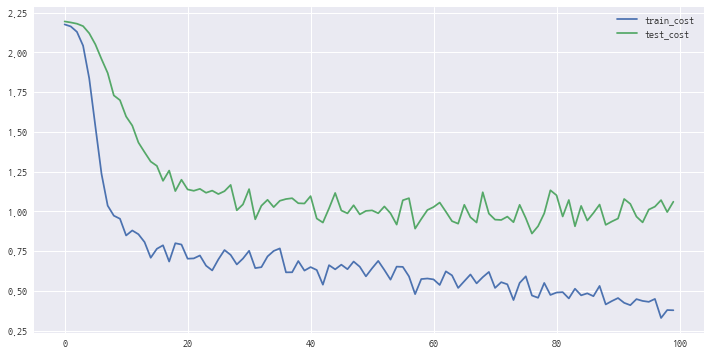

In [29]:
plt.figure(figsize=(12,6))
plt.plot(train_cost_ls, label = 'train_cost')
plt.plot(test_cost_ls, label = 'test_cost')

plt.legend(loc = 'best')